# Identifiation system basing on behavioral biometrics: typing errors

## Configuration
### Load dependencies

In [1]:
import pandas as pd
import tensorflow_decision_forests as tfdf
from sklearn.metrics import confusion_matrix

from create_model import create_dataset
import tensorflow as tf
import keras
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer, StandardScaler
from classifiers import build_tuned_nn, build_tuned_rfc, param_grid
from sklearn.neural_network import MLPClassifier
from os import path, makedirs
from create_model import create_dataset, NUMBER_OF_FEATURES, N_GRAM_SIZE
from sklearn.svm import SVC
from cv import run_cv_neural_network, run_cv
from cv import calculate_cmc, plot_cmc
from sklearn.model_selection import train_test_split
from ml_utils import compute_class_weights, create_weighted_dataset
import matplotlib.pyplot as plt

2023-09-11 00:18:15.955701: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 00:18:15.995995: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 00:18:15.996610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 00:18:16.830614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[]


### Configure GPUs

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

## Define constants

In [3]:
N_GRAM_SIZE = 2
NUMBER_OF_FEATURES=6

## Load dataset

In [4]:
X, y, X_test, y_test = create_dataset(n_gram_size=N_GRAM_SIZE, number_of_features=NUMBER_OF_FEATURES, test_ratio=0.5, if_separate_words=True, scaler=Normalizer())
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.2)

Alkinoos.json
Alkinoos.json
u_5.json
u_5.json
Zuzia Babol.json
Zuzia Babol.json
u_4.json
u_4.json
Kacper ZF.json
Kacper ZF.json
Mateusz.json
Mateusz.json
ZF Andrzej.json
ZF Andrzej.json
Agata.json
Agata.json
u_1.json
u_1.json
u_7.json
u_7.json
u_2.json
u_2.json
Cezary Babol.json
Cezary Babol.json
u_3.json
u_3.json
u_6.json
u_6.json
u_8.json
u_8.json
Lilou.json
Lilou.json
Bartek ZF.json
Bartek ZF.json
ZF Kamil.json
ZF Kamil.json
8 {'Alkinoos': 0, 'Jakub': 1, 'Zuzia Babol': 2, 'Jula': 3, 'Kacper ZF': 4, 'Mateusz': 5, 'ZF Andrzej': 6, 'Agata': 7, 'Babol': 8, 'Nata': 9, 'Bartek': 10, 'Cezary Babol': 11, 'Mieszko': 12, 'Miki': 13, 'Zuz': 14, 'Lilou': 15, 'Bartek ZF': 16, 'Kamil ZF': 17}
2023-09-11 00:18:19,227 — logger — ERROR — Requested 35000 combinations, but only 2080 are possible.
NoneType: None
2023-09-11 00:18:19,228 — logger — INFO — Dropped 0 duplcates.
4 {'Alkinoos': 0, 'Jakub': 1, 'Zuzia Babol': 2, 'Jula': 3, 'Kacper ZF': 4, 'Mateusz': 5, 'ZF Andrzej': 6, 'Agata': 7, 'Babol': 8, 

In [5]:
# class_weights = compute_class_weights(y)
# train_ds = create_weighted_dataset(X, y, class_weights)

### Create a tensorflow datasets

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((X, y)).batch(1000)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1000)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(1000)

## Define a tuner

In [7]:
tuner = tfdf.tuner.RandomSearch(num_trials=15)
tuner.choice("min_examples", [2, 5, 7, 10])
tuner.choice("categorical_algorithm", ["CART", "RANDOM"])
global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"])
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256])
tuner.choice("use_hessian_gain", [True, False])
tuner.choice("shrinkage", [0.02, 0.05, 0.10, 0.15])
tuner.choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0])
# model = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.CLASSIFICATION, tuner=tuner, l2_regularization=0.01)

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
2023-09-11 00:18:26,400 — absl — INFO — Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpq944y3oa as temporary training directory
2023-09-11 00:18:26,412 — absl — INFO — Use /tmp/tmpq944y3oa as temporary training directory


[WARNING 23-09-11 00:18:26.4149 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-11 00:18:26.4149 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-11 00:18:26.4150 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [16]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier

"""
model = tfdf.keras.GradientBoostedTreesModel(
    hyperparameter_template="benchmark_rank1",
    task=tfdf.keras.Task.CLASSIFICATION,
    tuner=tuner,
    l2_regularization=0.01)

model.compile(metrics=[tf.keras.metrics.AUC(name='auc')])
model.fit(train_ds, validation_data=valid_ds)
"""

model = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                    sampling_strategy='auto',
                                    replacement=False,
                                    random_state=0)
# model = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X, y)

BalancedBaggingClassifier(estimator=DecisionTreeClassifier(), random_state=0)

## Define a classifier

## Run cross-validation

In [17]:
y_pred = model.predict_proba(X_test)
cmc = calculate_cmc(y_test, y_pred)
cmc

array([0.28844735, 0.40835096, 0.48684405, 0.55402548, 0.61798554,
       0.66453548, 0.69965081, 0.72965131, 0.748709  , 0.76788964,
       0.78638174, 0.81739045, 0.85980918, 0.91976098, 0.95563862,
       0.97454876, 0.98913097, 1.        ])

In [9]:
y_pred = model.predict(test_ds, use_multiprocessing=True)
cmc = calculate_cmc(y_test, y_pred)
cmc

TypeError: AdaBoostClassifier.predict() got an unexpected keyword argument 'use_multiprocessing'

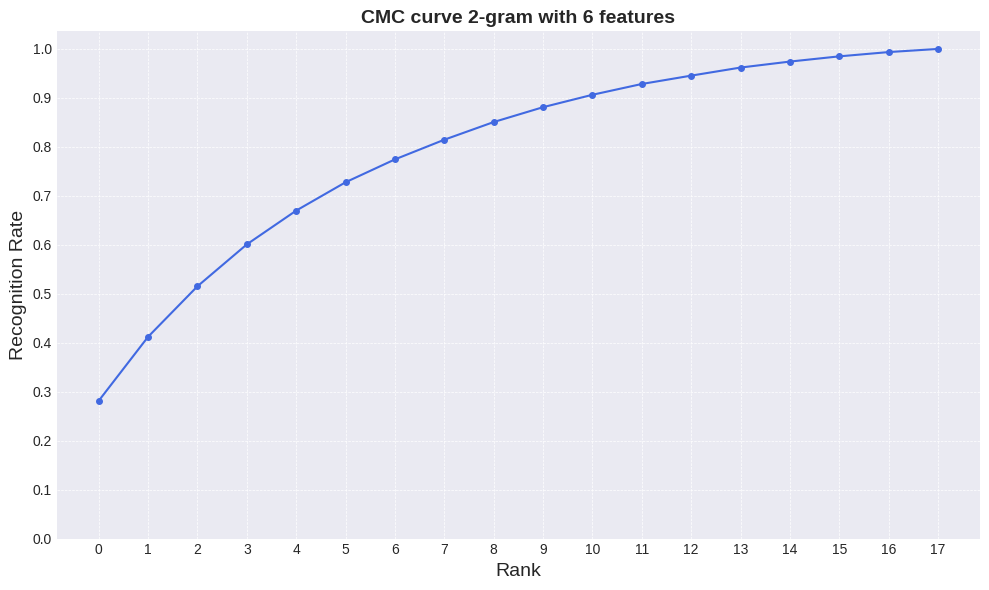

In [15]:
plot_cmc(cmc, f"CMC curve {N_GRAM_SIZE}-gram with {NUMBER_OF_FEATURES} features", f'plots/{N_GRAM_SIZE}_{NUMBER_OF_FEATURES}_boosting_cmc.png')

In [ ]:
import numpy as np
import seaborn as sns
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
class_names = np.unique(y_test)

In [ ]:
plt.figure(figsize=(18, 16))
sns.heatmap(cm, annot=True, fmt='g', cmap='RdYlGn', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
plot_cmc(cmc, f"CMC curve {N_GRAM_SIZE}-gram with {NUMBER_OF_FEATURES} features", f'plots/{N_GRAM_SIZE}_{NUMBER_OF_FEATURES}_boosting_cmc.png')

In [ ]:
template_model =  tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.CLASSIFICATION)
template_model.fit(train_ds)

In [ ]:
template_model.compile(metrics=["accuracy"])
y_pred = template_model.predict(test_ds, use_multiprocessing=True, workers=5)
evaluation = template_model.evaluate(test_ds)

In [ ]:
tuner.search(train_ds, validation_data=val_ds)

# Get the optimal hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model on combined training and validation data
best_model = tuner.hypermodel.build(best_hyperparameters)
combined_data = train_ds.concatenate(val_ds)
best_model.fit(combined_data)

# Predict on the test set
y_pred = best_model.predict(test_ds)
print(y_pred)